In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# A signal
x = np.array([10, 20, 15, 5, 0, 0, 0, 0], dtype=float)

# DCT
X = dct(x, norm='ortho')

# Inverse reconstruct
x_reconstructed = idct(X, norm='ortho')

print("Original signal:", x)
print("DCT coefficients:", np.round(X, 2))
print("Reconstructed signal:", np.round(x_reconstructed, 2))


Original signal: [10. 20. 15.  5.  0.  0.  0.  0.]
DCT coefficients: [17.68 17.87  3.27 -6.54 -7.07 -3.49 -1.35 -0.8 ]
Reconstructed signal: [10. 20. 15.  5.  0.  0. -0.  0.]


In [5]:
from scipy.fftpack import dct, idct

img = np.array([
    [52, 55, 61, 66, 70, 61, 64, 73],
    [63, 59, 55, 90, 109, 85, 69, 72],
    [62, 59, 68, 113, 144, 104, 66, 73],
    [63, 58, 71, 122, 154, 106, 70, 69],
    [67, 61, 68, 104, 126, 88, 68, 70],
    [79, 65, 60, 70, 77, 68, 58, 75],
    [85, 71, 64, 59, 55, 61, 65, 83],
    [87, 79, 69, 68, 65, 76, 78, 94]
], dtype=float)

# 2D DCT
dct2 = lambda x: dct(dct(x.T, norm='ortho').T, norm='ortho')
idct2 = lambda x: idct(idct(x.T, norm='ortho').T, norm='ortho')

dct_img = dct2(img)

reconstructed = idct2(dct_img)

print("DCT coefficients:\n", np.round(dct_img, 2))
print("\nReconstructed image:\n", np.round(reconstructed, 2))


DCT coefficients:
 [[ 6.0863e+02 -3.0190e+01 -6.1200e+01  2.7240e+01  5.6120e+01 -2.0100e+01
  -2.3900e+00  4.6000e-01]
 [ 4.4700e+00 -2.1860e+01 -6.0760e+01  1.0250e+01  1.3150e+01 -7.0900e+00
  -8.5400e+00  4.8800e+00]
 [-4.6830e+01  7.3700e+00  7.7130e+01 -2.4560e+01 -2.8910e+01  9.9300e+00
   5.4200e+00 -5.6500e+00]
 [-4.8530e+01  1.2070e+01  3.4100e+01 -1.4760e+01 -1.0240e+01  6.3000e+00
   1.8300e+00  1.9500e+00]
 [ 1.2120e+01 -6.5500e+00 -1.3200e+01 -3.9500e+00 -1.8800e+00  1.7500e+00
  -2.7900e+00  3.1400e+00]
 [-7.7300e+00  2.9100e+00  2.3800e+00 -5.9400e+00 -2.3800e+00  9.4000e-01
   4.3000e+00  1.8500e+00]
 [-1.0300e+00  1.8000e-01  4.2000e-01 -2.4200e+00 -8.8000e-01 -3.0200e+00
   4.1200e+00 -6.6000e-01]
 [-1.7000e-01  1.4000e-01 -1.0700e+00 -4.1900e+00 -1.1700e+00 -1.0000e-01
   5.0000e-01  1.6800e+00]]

Reconstructed image:
 [[ 52.  55.  61.  66.  70.  61.  64.  73.]
 [ 63.  59.  55.  90. 109.  85.  69.  72.]
 [ 62.  59.  68. 113. 144. 104.  66.  73.]
 [ 63.  58.  71. 122

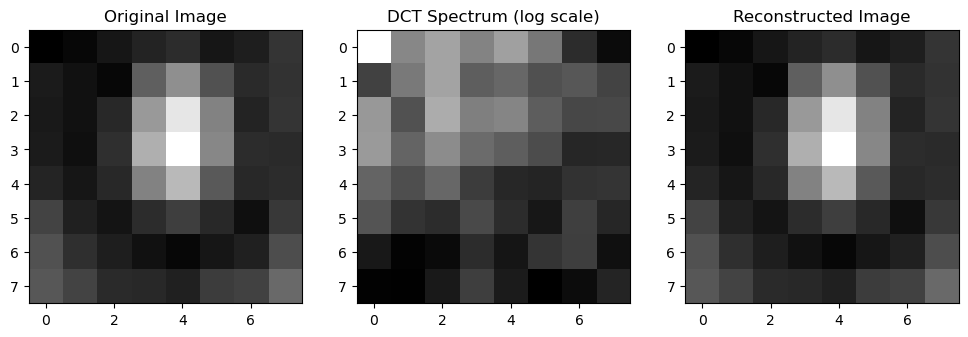

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(np.log1p(np.abs(dct_img)), cmap='gray')
plt.title("DCT Spectrum (log scale)")

plt.subplot(1,3,3)
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstructed Image")

plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage import color, io
import ipywidgets as widgets
from ipywidgets import interact

BLOCK = 8

Q_standard = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=float)

def get_quant_matrix(scale=1.0):
    return Q_standard * scale

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def blockify(img, block_size=8):
    h, w = img.shape
    h_crop = (h // block_size) * block_size
    w_crop = (w // block_size) * block_size
    img = img[:h_crop, :w_crop]
    blocks = (img.reshape(h_crop//block_size, block_size, -1, block_size)
                  .swapaxes(1,2)
                  .reshape(-1, block_size, block_size))
    return blocks, h_crop, w_crop

def unblockify(blocks, h, w, block_size=8):
    blocks = blocks.reshape(h//block_size, w//block_size, block_size, block_size)
    blocks = blocks.swapaxes(1,2)
    img = blocks.reshape(h, w)
    return img

def psnr(orig, recon):
    mse = np.mean((orig - recon)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def jpeg_like_compress(img_gray, quant_scale=1.0):
    img = img_gray.astype(float)
    blocks, H, W = blockify(img - 128.0, BLOCK)
    Q = get_quant_matrix(quant_scale)
    
    recon_blocks = []
    for B in blocks:
        D = dct2(B)
        Qb = np.round(D / Q)
        deQ = Qb * Q
        R = idct2(deQ)
        recon_blocks.append(R)
    
    recon_img = unblockify(np.array(recon_blocks), H, W, BLOCK) + 128.0
    recon_img = np.clip(recon_img, 0, 255)
    return recon_img.astype(np.uint8)

img_path = "hei.jpg" 
img_color = io.imread(img_path)
img_gray = color.rgb2gray(img_color) * 255
img_gray = img_gray.astype(np.uint8)
img_gray = img_gray[:256, :256]

@interact(scale=widgets.FloatSlider(value=1.0, min=0.5, max=5.0, step=0.5, description="Quant Scale"))
def update(scale=1.0):
    recon = jpeg_like_compress(img_gray, scale)
    p = psnr(img_gray.astype(float), recon.astype(float))
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(recon, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Reconstructed\nPSNR={p:.2f} dB")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(np.abs(img_gray.astype(float)-recon.astype(float)), cmap='magma')
    plt.title("Difference")
    plt.axis('off')
    
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='Quant Scale', max=5.0, min=0.5, step=0.5), Output())…

## 1. **Intuitive Understanding**

* DCT is a **transform technique** that converts a signal or image from the **spatial domain (pixels)** into the **frequency domain (cosine waves)**.
* In other words:

  * Before DCT: an image is just pixel intensity values.
  * After DCT: it becomes a set of coefficients that describe “how much of each cosine frequency is present.”

👉 Example:

* Top-left coefficient = overall brightness (low frequency).
* Bottom-right coefficients = fine details (high frequency).

---

## 2. **The Formula**

For a 1D sequence $x[n]$ of length $N$:

$$
X[k] = \alpha(k) \sum_{n=0}^{N-1} x[n] \cos \left[\frac{\pi}{N}\left(n + \tfrac{1}{2}\right)k \right]
$$

Where:

* $x[n]$: input values (pixels).
* $X[k]$: DCT coefficients.
* $\alpha(k)$: normalization factor:

  $$
  \alpha(k) = 
  \begin{cases} 
  \sqrt{\tfrac{1}{N}}, & k = 0 \\[6pt]
  \sqrt{\tfrac{2}{N}}, & k > 0
  \end{cases}
  $$

For **2D DCT** (images), we apply DCT along rows and then along columns:

$$
X[u,v] = \alpha(u)\alpha(v) \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) 
\cos\Bigg[\frac{\pi}{M}(x+\tfrac{1}{2})u\Bigg] 
\cos\Bigg[\frac{\pi}{N}(y+\tfrac{1}{2})v\Bigg]
$$

---

## 3. **Why Cosine?**

* DFT (Discrete Fourier Transform) uses both sine and cosine.
* DCT only uses cosine → better for images, because images usually have **symmetry at the boundaries**.
* This makes energy **concentrate in fewer coefficients**, especially in the low-frequency part.

---

## 4. **DCT in Image Compression (JPEG)**

JPEG uses DCT as the core step:

1. Split image into **8×8 blocks**.
2. Apply **2D DCT** to each block.
3. Most energy goes into a few coefficients (top-left).
4. High-frequency coefficients (bottom-right) are often small → we can **quantize or discard** them.
5. Result: huge file size reduction with little visual loss.

---

## 5. **What is Qstand?**

“Qstand” usually refers to the **Quantization Standard Table** used in JPEG compression.

* After DCT, each coefficient is divided by a number from this table and rounded.
* Low-frequency values have **small divisors** (so they’re preserved).
* High-frequency values have **large divisors** (so they shrink to zero).

👉 This matches human vision: we care more about smooth regions (low-frequency) than tiny details (high-frequency).

---

## 6. **Summary**

* DCT converts pixel data into cosine frequency coefficients.
* Low frequencies = structure, brightness.
* High frequencies = edges, details.
* JPEG compression keeps low frequencies, discards/quantizes high ones.
